In [1]:
import pandas as pd
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import numpy as np
import seaborn as sns


In [2]:
# Load the dataset
data = pd.read_csv('data/merged_data.csv')
data['DATE'] = pd.to_datetime(data['DATE'])
data.set_index('DATE', inplace=True)

# Split the data into training and testing (post-2000)
train_data = data[data.index.year <= 2000]
test_data = data[data.index.year > 2000]

# Separate columns for different scalers
standard_scaler_columns = ['Slope', 'LongTermRate']
min_max_scaler_columns = ['ZeroCouponYield1Y', 'ZeroCouponYield10Y']

# Apply StandardScaler to selected columns
standard_scaler = StandardScaler()
train_data[standard_scaler_columns] = standard_scaler.fit_transform(train_data[standard_scaler_columns])
test_data[standard_scaler_columns] = standard_scaler.transform(test_data[standard_scaler_columns])

# Apply MinMaxScaler to the yield data
yield_scaler = MinMaxScaler()
combined_yields = pd.concat([train_data[min_max_scaler_columns], test_data[min_max_scaler_columns]])
yield_scaler.fit(combined_yields)  # Fit scaler on combined data to get global min/max values
train_data[min_max_scaler_columns] = yield_scaler.transform(train_data[min_max_scaler_columns])
test_data[min_max_scaler_columns] = yield_scaler.transform(test_data[min_max_scaler_columns])



# Prepare the training and testing features
X_train = train_data.drop(columns=['Recession'])
X_test = test_data.drop(columns=['Recession'])


# Train the HMM using the training data
n_states = 2  # Number of regimes
hmm_model = GaussianHMM(n_components=n_states, covariance_type="full", random_state=42, n_iter=1000)
hmm_model.fit(X_train)

# Predict hidden states (regimes) for both training and testing data
train_hidden_states = hmm_model.predict(X_train)
test_hidden_states = hmm_model.predict(X_test)

# Add predicted regimes back to the dataset
data.loc[train_data.index, 'Regime'] = train_hidden_states
data.loc[test_data.index, 'Regime'] = test_hidden_states



C:\Users\chris\AppData\Local\Temp\ipykernel_23124\1620770198.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[standard_scaler_columns] = standard_scaler.fit_transform(train_data[standard_scaler_columns])
C:\Users\chris\AppData\Local\Temp\ipykernel_23124\1620770198.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[standard_scaler_columns] = standard_scaler.transform(test_data[standard_scaler_columns])
C:\Users\chris\AppData\Local\Temp\ipykernel_23124\1620770198.py:23: SettingWithC

### View Predictions

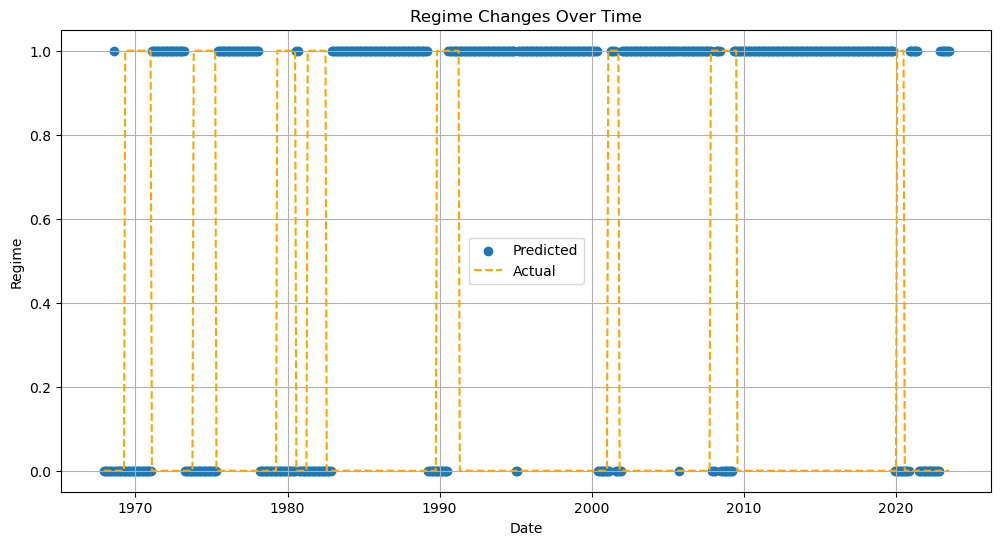

array([[0.94923411, 0.05076589],
       [0.02890727, 0.97109273]])

In [3]:
plt.figure(figsize=(12, 6))
plt.scatter(data.index, data['Regime'], label='Predicted')
plt.plot(data.index, data['Recession'], label='Actual', color='orange', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Regime')
plt.title('Regime Changes Over Time')
plt.grid(True)
plt.legend()
plt.show()

hmm_model.transmat_

### Score Model

Accuracy: 0.17
Precision: 0.04
Recall: 0.17
F1-Score: 0.07

Confusion Matrix:
[[ 92 453]
 [102  21]]


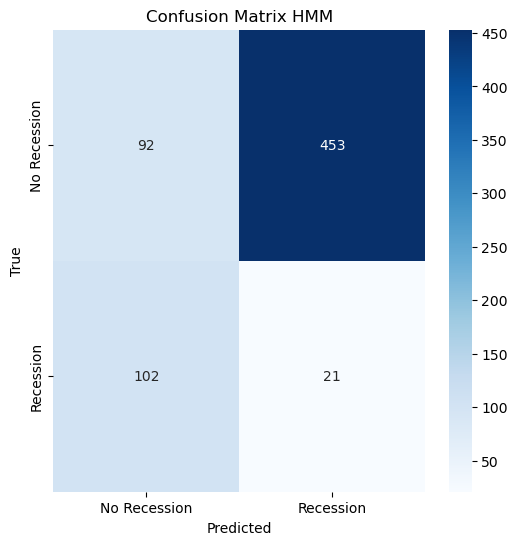

In [4]:
# Map the predicted regimes to recession and no-recession labels
data['PredictedRecession'] = np.where(data['Regime'] == 1, 1, 0)

# True labels and predicted labels
y_true = data['Recession']
y_pred = data['PredictedRecession']

# Classification metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print("\nConfusion Matrix:")
print(conf_matrix)

# Visualize the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Recession", "Recession"],
            yticklabels=["No Recession", "Recession"])
plt.title("Confusion Matrix HMM")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


### View transition probabilities

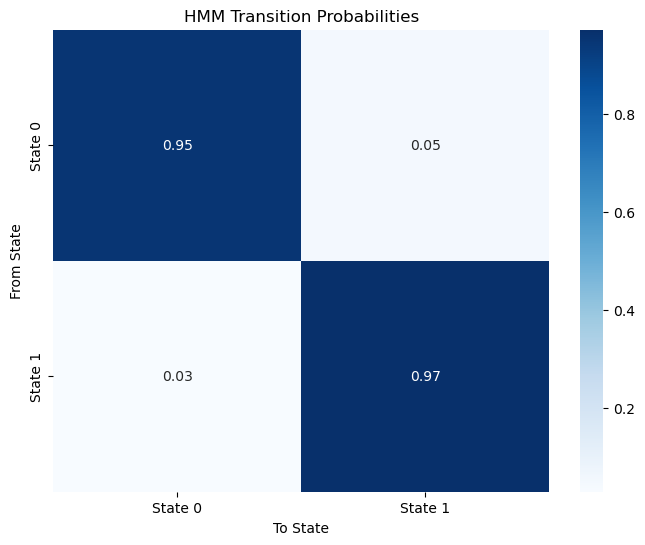

In [5]:
# Extract the transition matrix
transition_matrix = hmm_model.transmat_

plt.figure(figsize=(8, 6))
sns.heatmap(transition_matrix, annot=True, fmt=".2f", cmap="Blues", 
            xticklabels=[f"State {i}" for i in range(transition_matrix.shape[0])],
            yticklabels=[f"State {i}" for i in range(transition_matrix.shape[0])])
plt.title("HMM Transition Probabilities")
plt.xlabel("To State")
plt.ylabel("From State")
plt.show()
